# 1. API 호출

In [1]:
import os
import sys
import urllib.request
import json
import re
import pandas as pd

In [2]:
client_id = "client id를 입력해주세요"
client_secret = "client secret을 입력해주세요"

url = "https://openapi.naver.com/v1/datalab/search"
body = "{\"startDate\":\"2019-01-01\",\"endDate\":\"2022-12-31\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"마켓컬리\",\"keywords\":[\"마켓컬리\",\"마켓 컬리\",\"컬리\",\"market kurly\"]},{\"groupName\":\"오아시스마켓\",\"keywords\":[\"오아시스마켓\",\"오아시스 마켓\", \"oasis market\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()

if(rescode==200):
    response_body = response.read()
    query = response_body.decode('utf-8')
    data_query = json.loads(query)
else:
    print("Error Code:" + rescode)

# 2. 데이터 전처리

In [3]:
dates = []
kurly_queries = []
for i in data_query['results'][0]['data']:
    dates.append(i['period'])
    kurly_queries.append(i['ratio'])

oasis_queries = []
for i in data_query['results'][1]['data']:
    oasis_queries.append(i['ratio'])

df = pd.DataFrame([dates, kurly_queries, oasis_queries]).T
df.columns = ['Date', 'kurly', 'oasis']

import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df['kurly'] = df['kurly'].astype(int)
df['oasis'] = df['oasis'].astype(int)

In [4]:
df

,Date,kurly,oasis
0,2019-01-01,11,0
1,2019-01-02,15,0
2,2019-01-03,17,0
3,2019-01-04,16,0
4,2019-01-05,11,0
...,...,...,...
1456,2022-12-27,38,5
1457,2022-12-28,37,5
1458,2022-12-29,36,5
1459,2022-12-30,27,6


# 3. 시각화

In [5]:
# 패키지
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = "Malgun Gothic"
plt.rcParams['axes.grid'] = False

import plotly.express as px

## 3.1. 마켓컬리 검색 트렌드

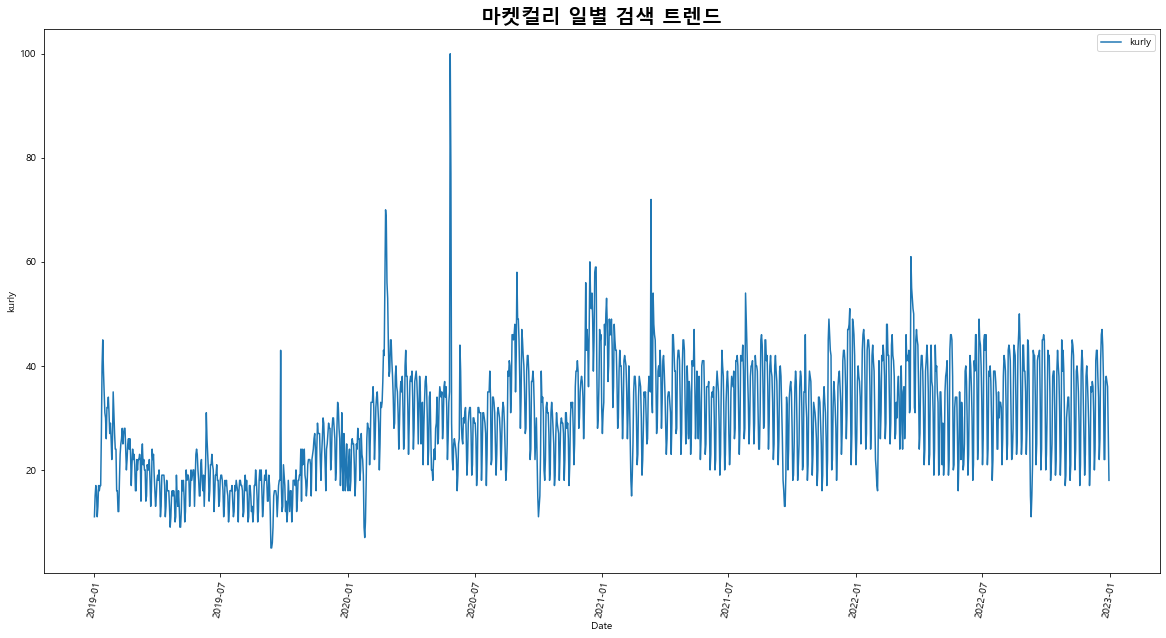

In [6]:
# 마켓컬리의 일별 검색 트렌드
fig = plt.figure(figsize=(20,10))
plt.title("마켓컬리 일별 검색 트렌드", size=20, weight='bold')

sns.lineplot(x=df['Date'], y=df['kurly'], label='kurly')
plt.legend(loc='upper right')
plt.xticks(rotation=80)
plt.show()

In [7]:
# 월별 검색건수 sum
df['YearMonth'] = df['Date'].astype(str).str[:7]
df = df[['Date', 'YearMonth', 'kurly', 'oasis']]
df_month = df.groupby(by='YearMonth').sum().reset_index()

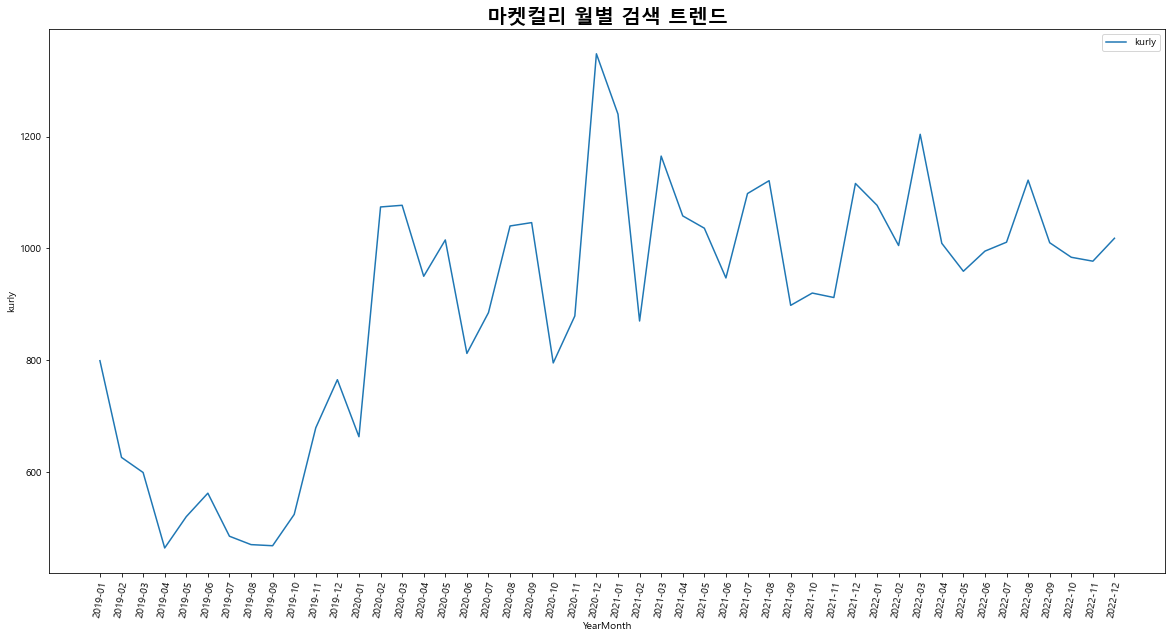

In [8]:
# 마켓컬리의 월별 검색 트렌드
fig = plt.figure(figsize=(20,10))
plt.title("마켓컬리 월별 검색 트렌드", size=20, weight='bold')

sns.lineplot(x=df_month['YearMonth'], y=df_month['kurly'], label='kurly')
plt.legend(loc='upper right')
plt.xticks(rotation=80)
plt.show()

## 3.2. 마켓컬리&오아시스마켓 검색 트렌드

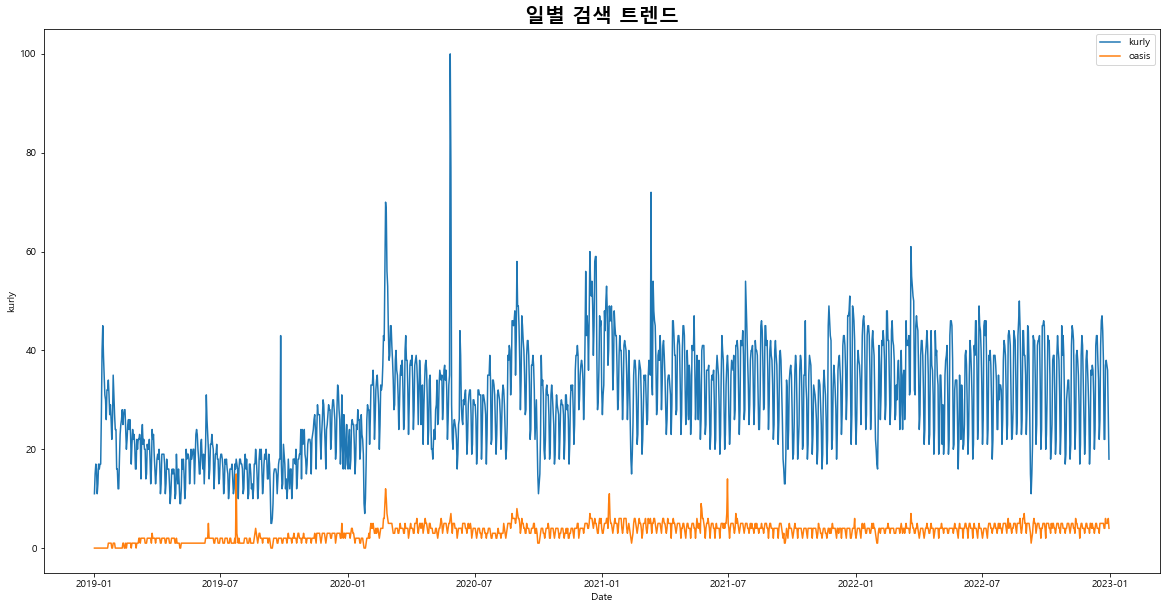

In [9]:
# 일별 검색 트렌드 그래프
colList = df.columns[2:]
n_col = len(colList)
fig = plt.figure(figsize=(20,10))
plt.title("일별 검색 트렌드", size=20, weight='bold')

for i in range(n_col):
    sns.lineplot(x=df['Date'], y=df[colList[i]], label=colList[i])
plt.legend(loc='upper right')

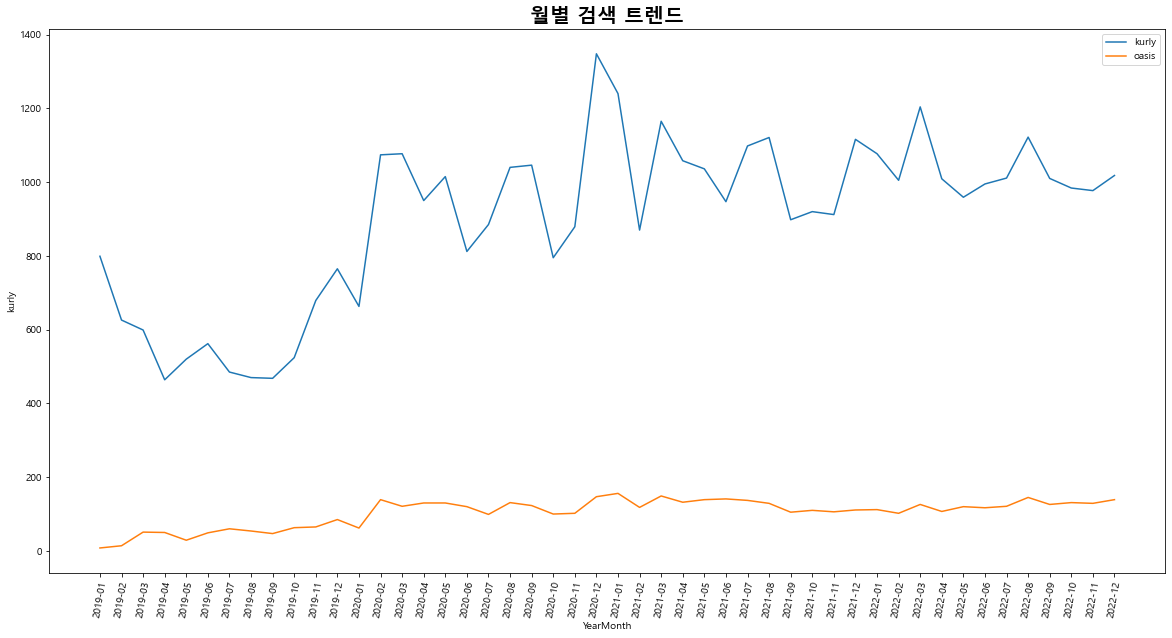

In [10]:
# 월별 검색 트렌드 그래프
colList_month = df_month.columns[1:]
n_col_month = len(colList_month)
fig = plt.figure(figsize=(20,10))
plt.title("월별 검색 트렌드", size=20, weight='bold')

for i in range(n_col_month):
    sns.lineplot(x=df_month['YearMonth'], y=df_month[colList[i]], label=colList[i])
plt.legend(loc='upper right')
plt.xticks(rotation=80)
plt.show()

In [11]:
# 일별 데이터의 상관계수 확인
df[['kurly', 'oasis']].corr()

,kurly,oasis
kurly,1.000000,0.743698
oasis,0.743698,1.000000


In [12]:
# 월별 데이터의 상관계수 확인
df_month[['kurly', 'oasis']].corr()

,kurly,oasis
kurly,1.000000,0.863973
oasis,0.863973,1.000000


# 4. 성장 요인

## 4.1. 코로나와의 관련성
* 2020~2022년 국내 코로나 발생현황 데이터만 활용

In [13]:
covid = pd.read_excel("./COVID19_발생현황.xlsx", sheet_name=0)
covid = covid[(covid['일자'].dt.year == 2020) | (covid['일자'].dt.year == 2021) | (covid['일자'].dt.year == 2022)]

<AxesSubplot:xlabel='일자', ylabel='국내발생(명)'>

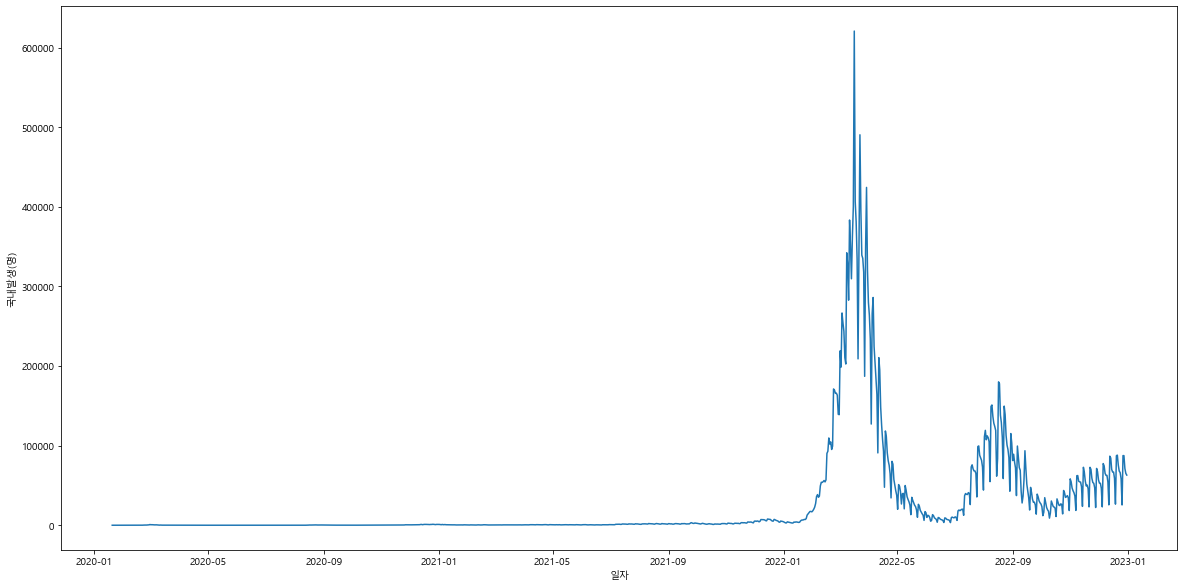

In [14]:
# 코로나 추이 그래프
fig = plt.figure(figsize=(20,10))
sns.lineplot(x=covid['일자'], y=covid['국내발생(명)'])

### 4.1.1. 2020년 추이

In [15]:
df_key_co = pd.merge(df, covid, left_on='Date', right_on='일자', how='inner')
df_key_co

,Date,YearMonth,kurly,oasis,일자,계(명),국내발생(명),해외유입(명),사망(명)
0,2020-01-20,2020-01,27,2,2020-01-20,1,0,1,0
1,2020-01-21,2020-01,23,2,2020-01-21,0,0,0,0
2,2020-01-22,2020-01,22,2,2020-01-22,0,0,0,0
3,2020-01-23,2020-01,19,1,2020-01-23,0,0,0,0
4,2020-01-24,2020-01,9,0,2020-01-24,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1072,2022-12-27,2022-12,38,5,2022-12-27,87573,87507,66,50
1073,2022-12-28,2022-12,37,5,2022-12-28,87481,87425,56,69
1074,2022-12-29,2022-12,36,5,2022-12-29,71392,71320,72,76
1075,2022-12-30,2022-12,27,6,2022-12-30,65194,65125,69,68


In [16]:
# 2020년일 때 마켓컬리, 오아시스마켓과 국내 코로나 확진자 수 사이에 상관계수
df_key_co.loc[:346][['kurly', 'oasis', '국내발생(명)']].corr()

,kurly,oasis,국내발생(명)
kurly,1.000000,0.801149,0.436287
oasis,0.801149,1.000000,0.288036
국내발생(명),0.436287,0.288036,1.000000


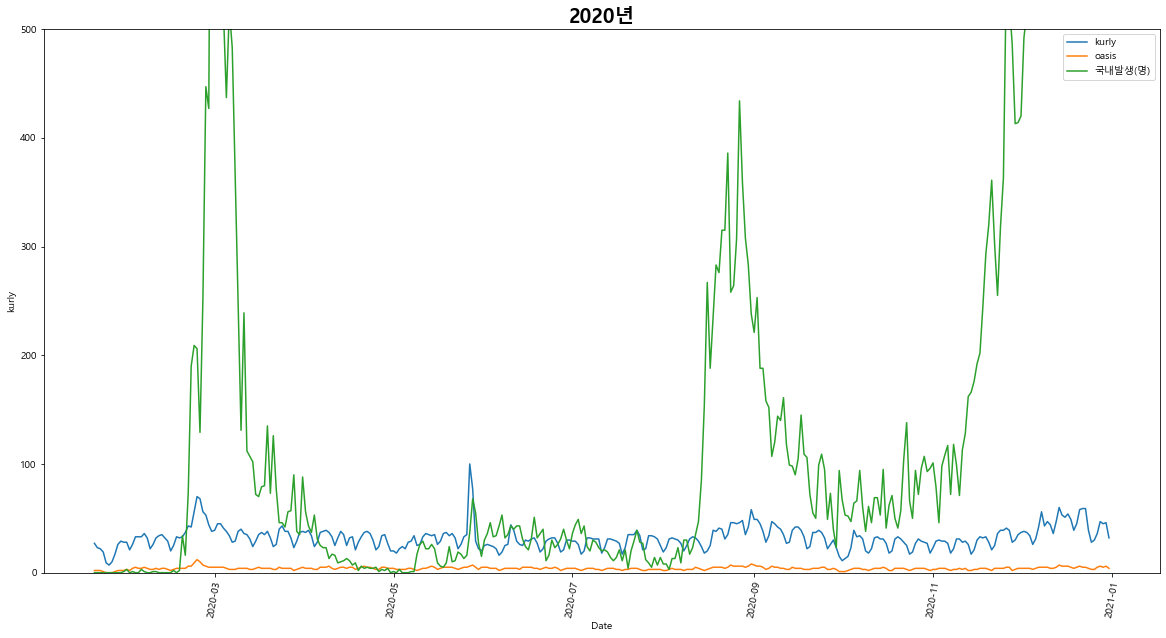

In [17]:
# 2020년일 때 마켓컬리, 오아시스마켓과 국내 코로나 확진자 수의 변화 추이 비교
df_key_co_2020 = df_key_co.loc[:346]

colList_m = ['kurly', 'oasis', '국내발생(명)']
n_col_m = len(colList_m)
fig = plt.figure(figsize=(20,10))
plt.title("2020년", size=20, weight='bold')

for i in range(n_col_m):
    sns.lineplot(x=df_key_co_2020['Date'], y=df_key_co_2020[colList_m[i]], label=colList_m[i])
plt.legend(loc='upper right')
plt.xticks(rotation=80)
plt.ylim(0,500)
plt.show()